In [1]:
!pip install torch torchvision torchsummary numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1630znPVh4OvgBDVXExEn0M2cWB-qL-HA/view?usp=sharing
!unzip "771data.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1630znPVh4OvgBDVXExEn0M2cWB-qL-HA
From (redirected): https://drive.google.com/uc?id=1630znPVh4OvgBDVXExEn0M2cWB-qL-HA&confirm=t&uuid=79359bb0-69ee-4062-abf7-b6e222001288
To: /content/771data.zip
100% 95.9M/95.9M [00:01<00:00, 94.9MB/s]
Archive:  771data.zip
   creating: TaskB/
   creating: TaskB/Model1/
  inflating: TaskB/Model1/model1_test.pth  
   creating: TaskB/Model2/
  inflating: TaskB/Model2/model2_test.pth  
   creating: TaskB/Model3/
  inflating: TaskB/Model3/model3_test.pth  
   creating: TaskB/Models/
  inflating: TaskB/Models/merged_model_finetuned.pth  
  inflating: TaskB/Models/model1.pth  
  inflating: TaskB/Models/model2.pth  
  inflating: TaskB/Models/model3.pth  
  inflating: TaskB/taskB.py          
  inflating: cifar100_classes.txt    
   creating: TaskA/
  inflating: TaskA/main.py           
   creating: TaskA/Model1/
  inflating: TaskA/Model1/model1_test.pth  
  inflating: TaskA/Model1/model1_train.pth

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import random
import sys
sys.path.append('/content/TaskA')
sys.path.append('/content/TaskB')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
processed_lines = []
classes_names_A = []
# Open and read the file line by line
with open('/content/cifar100_classes.txt', 'r') as file:
  for line in file:
    # Remove leading and trailing whitespace and normalize spaces within the line
    cleaned_line = ' '.join(line.strip().split())
    processed_lines.append(cleaned_line)

    # Convert the list to a NumPy array
  classes_names_A = np.array(processed_lines)
# print(classes_names)

In [5]:
def display_images(all_images, all_labels, all_preds, class_keys, idx, model, classes_names):
  # Create the figure
  fig = plt.figure(figsize=(15,6))
  if model > -1:
    title = f"Model {model+1} Sample Images"
  else:
    title = "Fusion Model Sample Images"
  fig.suptitle(title, fontsize=16, y=1.05)
  rows, cols = 2, 5
  for i in range(len(idx)):
    ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
    # Get the image and convert from tensor
    img = all_images[i]
    if len(img.shape) == 4:  # If there's an extra batch dimension [B,C,H,W]
      img = img.squeeze(0)  # Remove batch dimension -> [C,H,W]
    # Denormalize if needed
    if img.min() < 0 or img.max() > 1:
      # Assuming standard normalization with mean [0.485, 0.456, 0.406] and std [0.229, 0.224, 0.225]
      inv_normalize = transforms.Compose([
          transforms.Normalize(
              mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
              std=[1/0.229, 1/0.224, 1/0.225]
              )
          ])
      img = inv_normalize(img)
    # Convert tensor to image
    img = img.permute(1, 2, 0).numpy()  # Change from [C,H,W] to [H,W,C]
    img = np.clip(img, 0, 1)  # Clip values to valid range

    # Display the image
    ax.imshow(img)

    # Get true and predicted labels
    true_label = class_keys[all_labels[i]]
    pred_label = class_keys[all_preds[i]]

    # Format the label text
    title = f"True: {classes_names[true_label]}\nPrediction: {classes_names[pred_label]}"
    # Color green if correct, red if wrong
    color = "green" if true_label == pred_label else "red"
    ax.set_title(title, color=color)

# plt.tight_layout()
# plt.show()

  # return fig

## Task A


===== Evaluating Model 1 =====
Accuracy: 0.9140
Precision: 0.9136
Recall: 0.9140
F1 Score: 0.9128


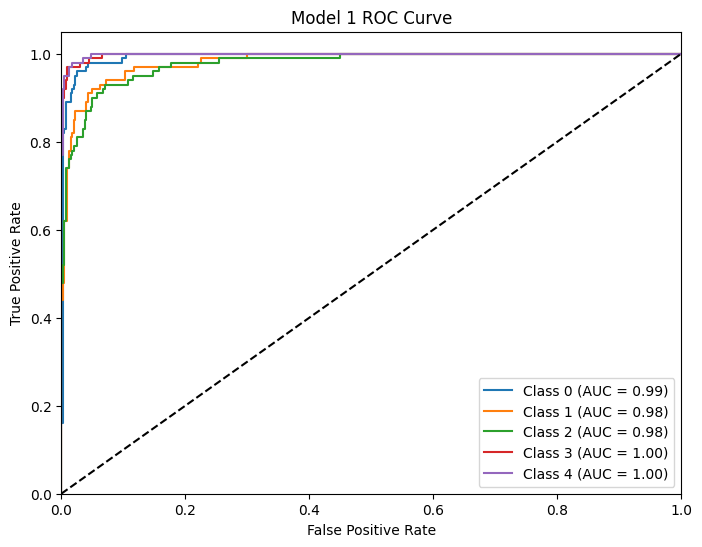

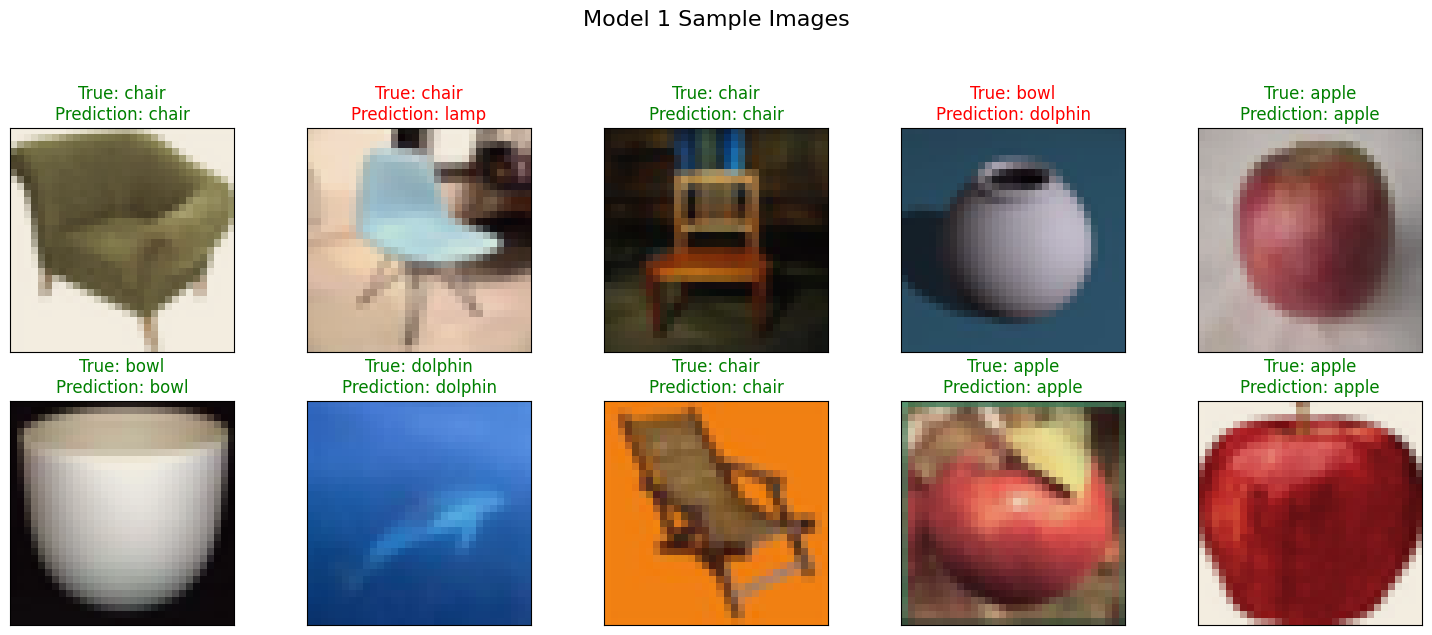


===== Evaluating Model 2 =====
Accuracy: 0.9300
Precision: 0.9318
Recall: 0.9300
F1 Score: 0.9300


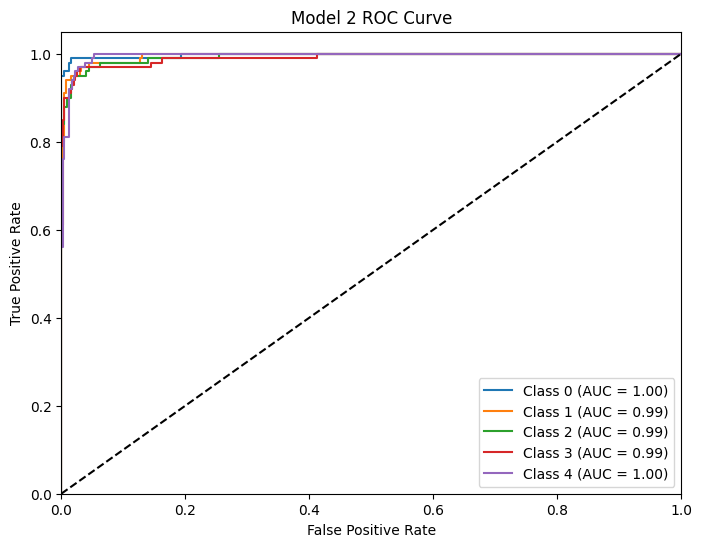

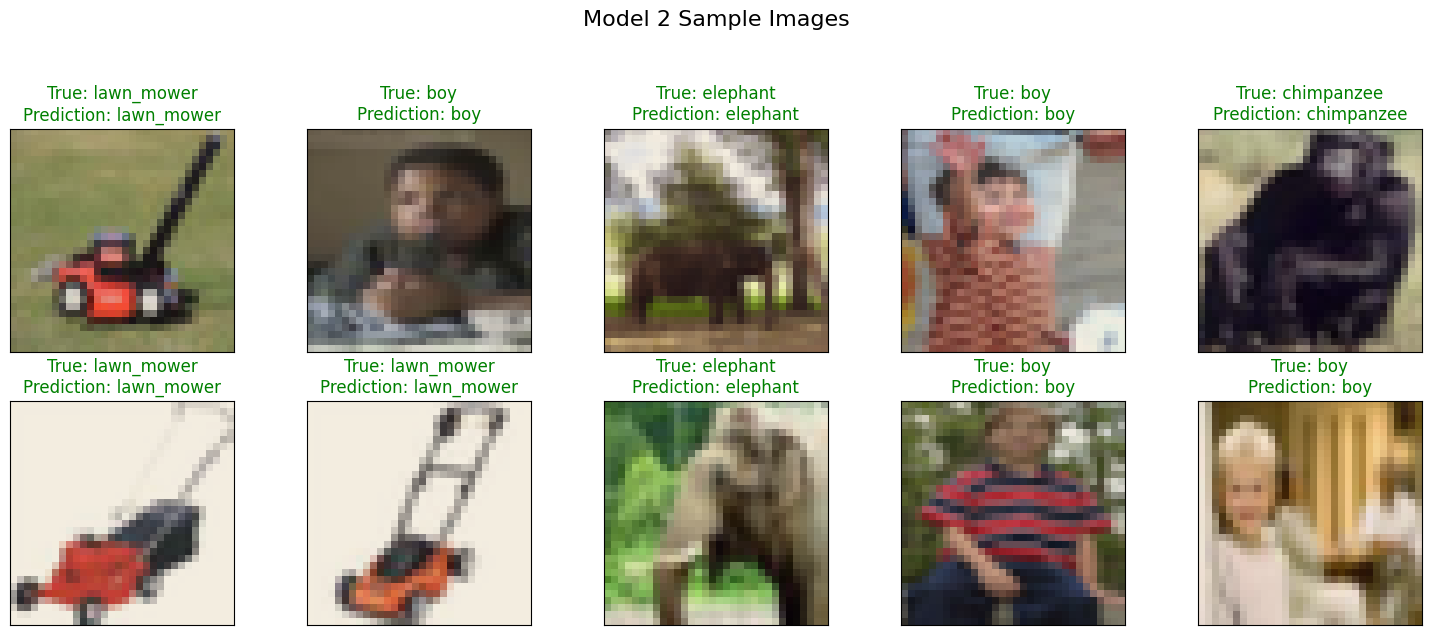


===== Evaluating Model 3 =====
Accuracy: 0.8420
Precision: 0.8466
Recall: 0.8420
F1 Score: 0.8410


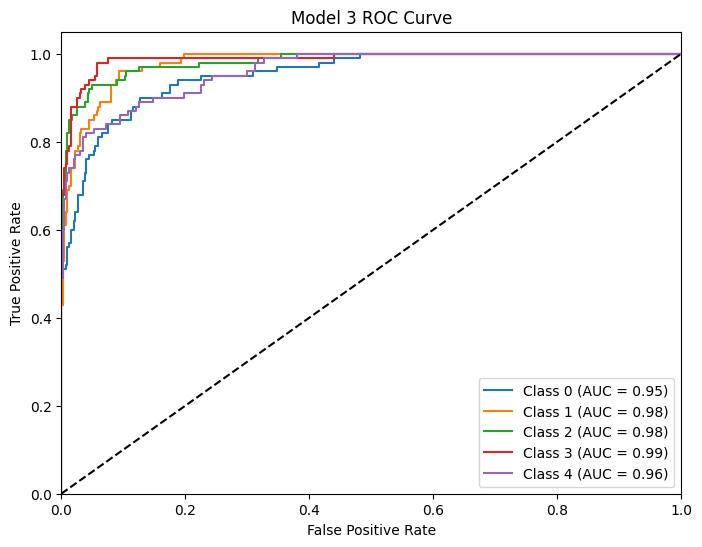

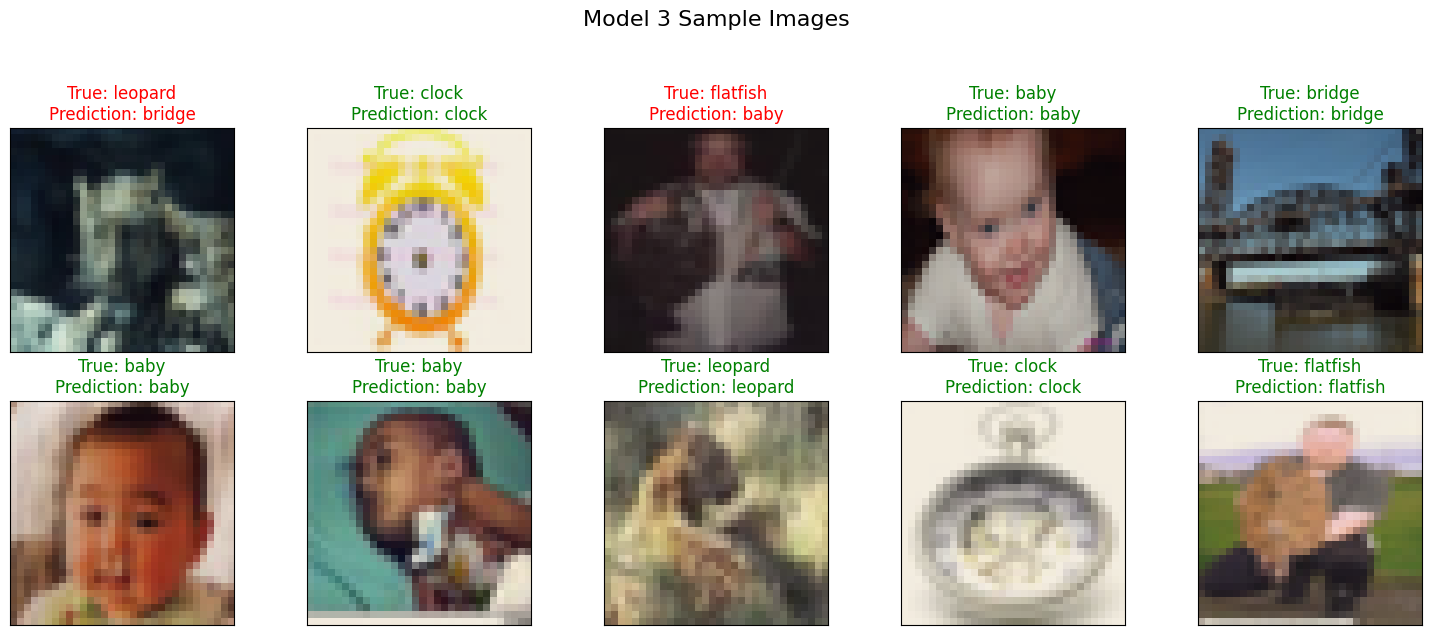

In [6]:
from main import CustomDataset, CustomCNN, test_transform, load_data

subclass_files = [
    {
        "test": "/content/TaskA/Model1/model1_test.pth",
        "model_path": "/content/TaskA/Models/model1.pth",
        "mapping": {0: 0, 40: 1, 10: 2, 20: 3, 30: 4}
    },
    {
        "test": "/content/TaskA/Model2/model2_test.pth",
        "model_path": "/content/TaskA/Models/model2.pth",
        "mapping": {1: 0, 41: 1, 11: 2, 21: 3, 31: 4}
    },
    {
        "test": "/content/TaskA/Model3/model3_test.pth",
        "model_path": "/content/TaskA/Models/model3.pth",
        "mapping": {32: 0, 2: 1, 42: 2, 12: 3, 22: 4}
    }
]

def evaluate_model(model, test_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    all_images = []
    count = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            all_images.append(inputs.cpu())
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_images = torch.cat(all_images, 0)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return all_images, all_preds, all_labels, all_probs, accuracy, precision, recall, f1


def plot_roc_curve(y_true, y_score, num_classes, model_index):
    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Model {model_index + 1} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def main():
    for i, files in enumerate(subclass_files):
        print(f"\n===== Evaluating Model {i + 1} =====")

        test_data, test_labels = load_data(files["test"])
        mapping = files["mapping"]
        test_labels_tensor = torch.tensor([mapping[label] for label in test_labels], dtype=torch.long)

        test_dataset = CustomDataset(test_data, test_labels_tensor, transform=test_transform)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = CustomCNN(num_classes=5).to(device)
        model.load_state_dict(torch.load(files["model_path"], map_location=device))

        all_img, all_preds, y_true, y_score, acc, prec, rec, f1 = evaluate_model(model, test_loader, num_classes=5)

        plot_roc_curve(y_true, y_score, num_classes=5, model_index=i)

        num_total = len(all_img)
        indices = random.sample(range(num_total), 10)

        fig = display_images(all_img[indices], y_true[indices], all_preds[indices], list(mapping.keys()), indices, i, classes_names_A)
        plt.tight_layout()
        plt.show()
main()

# Task B


===== Evaluating Model 1 =====
Accuracy: 0.4520
Precision: 0.3990
Recall: 0.4520
F1 Score: 0.4027


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


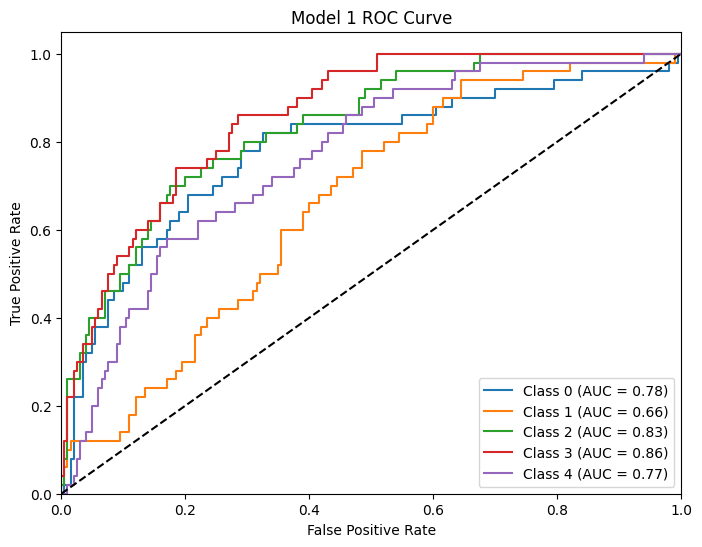

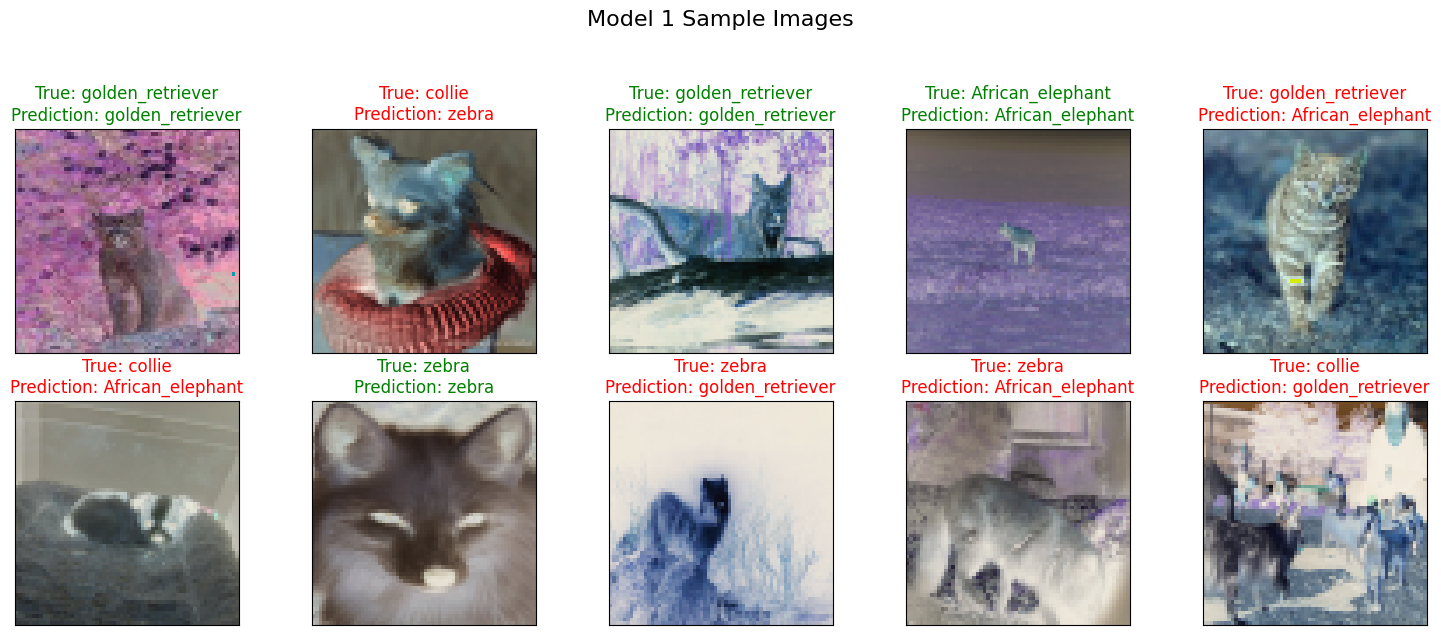


===== Evaluating Model 2 =====
Accuracy: 0.8720
Precision: 0.8748
Recall: 0.8720
F1 Score: 0.8721


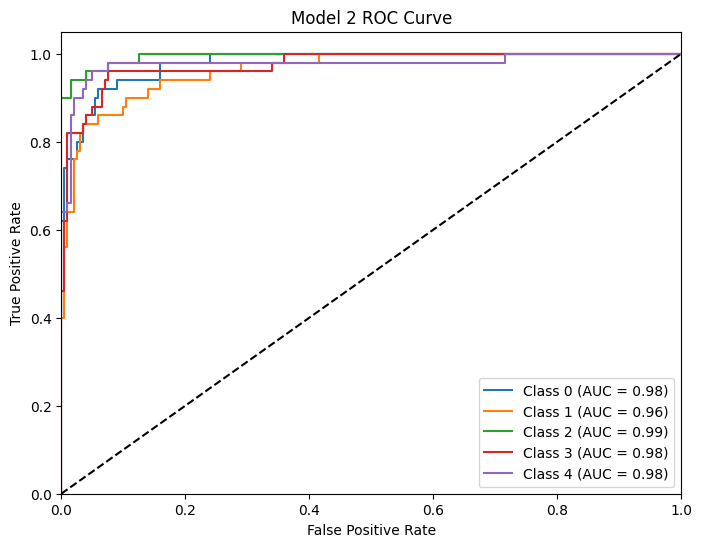

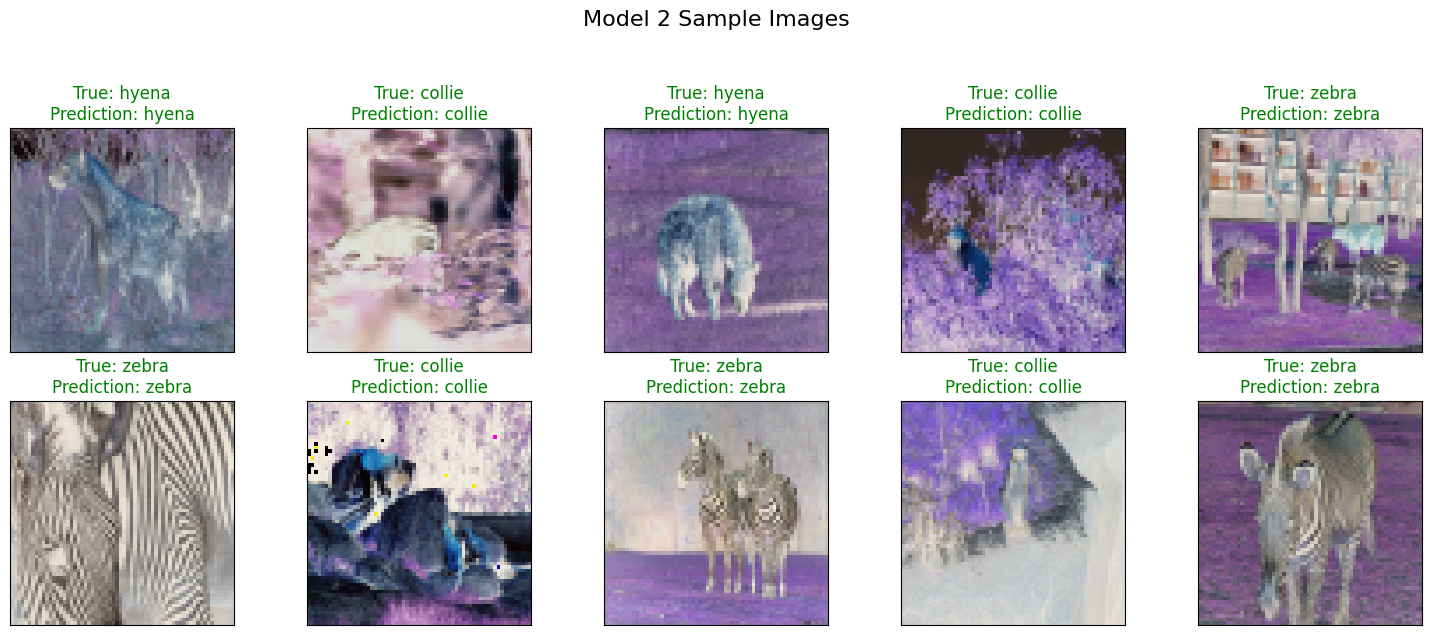


===== Evaluating Model 3 =====
Accuracy: 0.6520
Precision: 0.6514
Recall: 0.6520
F1 Score: 0.6487


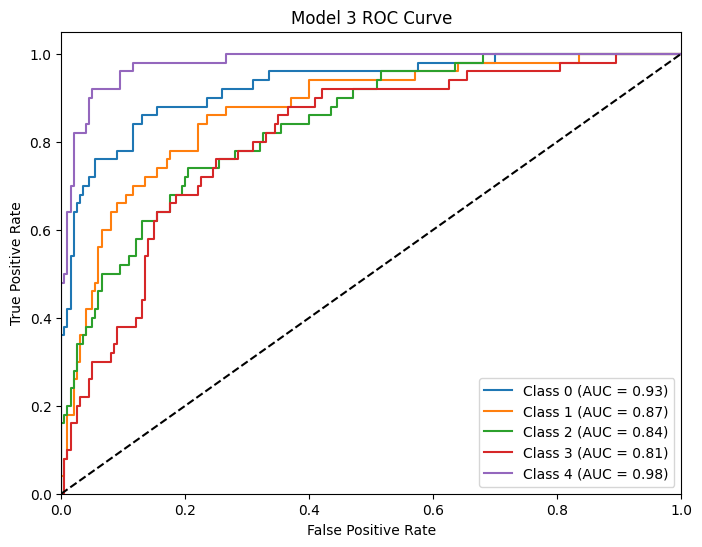

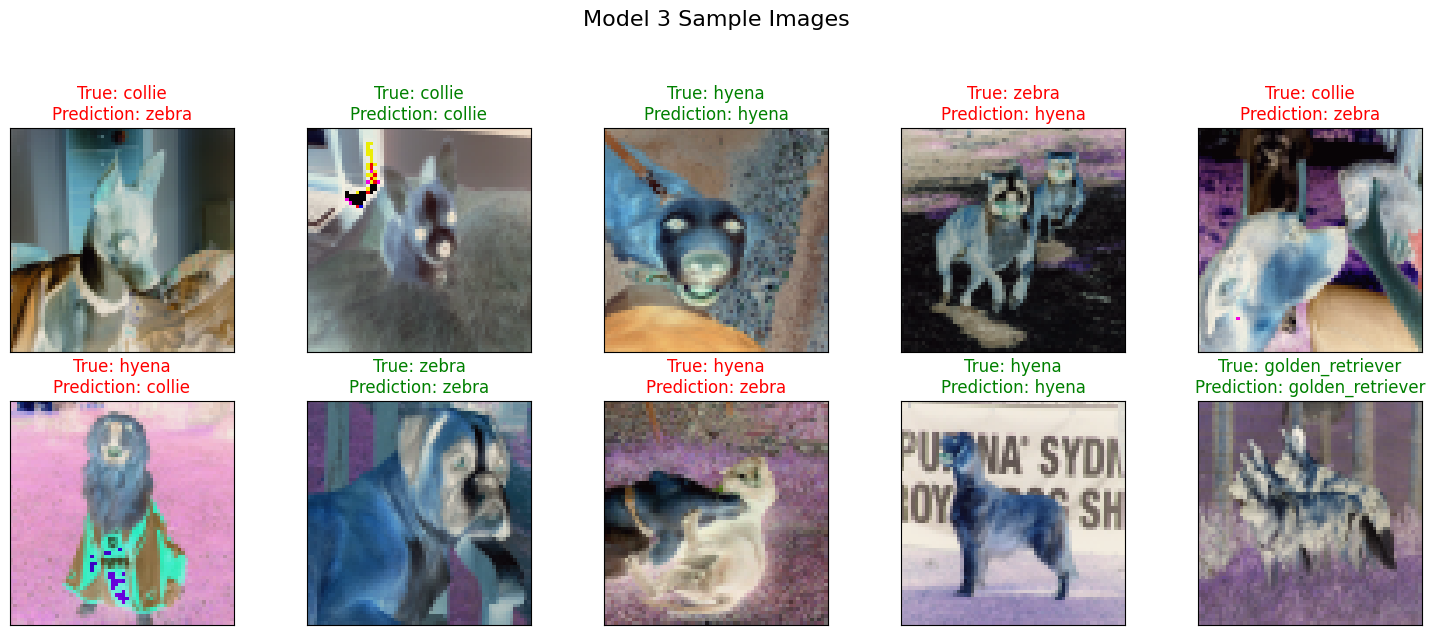

In [7]:
from taskB import CustomDataset, CustomCNN, test_transform, load_data

classes_names_B = [
        "African_elephant",
        "hyena",
        "zebra",
        "collie",
        "golden_retriever",
        "boxer",
        "patas",
        "baboon",
        "Arctic_fox",
        "Chihuahua",
        "lynx",
        "African_hunting_dog"
    ]

subclass_files = [
    {
        "test": "/content/TaskB/Model1/model1_test.pth",
        "model_path": "/content/TaskB/Models/model1.pth",
        "mapping": {34: 0, 137: 1, 159: 2, 173: 3, 201: 4}
    },
    {
        "test": "/content/TaskB/Model2/model2_test.pth",
        "model_path": "/content/TaskB/Models/model2.pth",
        "mapping": {24: 0, 34: 1, 80: 2, 135: 3, 202: 4}
    },
    {
        "test": "/content/TaskB/Model3/model3_test.pth",
        "model_path": "/content/TaskB/Models/model3.pth",
        "mapping": {124: 0, 125: 1, 130: 2, 173: 3, 202: 4}
    }
]

def evaluate_model(model, test_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    all_images = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            all_images.append(inputs.cpu())
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_images = torch.cat(all_images, 0)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return all_images, all_preds, all_labels, all_probs, accuracy, precision, recall, f1

def plot_roc_curve(y_true, y_score, num_classes, model_index):
    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Model {model_index + 1} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


def main():
    for i, files in enumerate(subclass_files):
        print(f"\n===== Evaluating Model {i + 1} =====")

        test_data, test_labels = load_data(files["test"])
        mapping = files["mapping"]
        test_labels_tensor = torch.tensor([mapping[int(label.item())]  for label in test_labels], dtype=torch.long)

        test_dataset = CustomDataset(test_data, test_labels_tensor, transform=test_transform)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = CustomCNN(num_classes=5).to(device)
        model.load_state_dict(torch.load(files["model_path"], map_location=device))

        all_img, all_preds, y_true, y_score, acc, prec, rec, f1 = evaluate_model(model, test_loader, num_classes=5)

        plot_roc_curve(y_true, y_score, num_classes=5, model_index=i)

        num_total = len(all_img)
        indices = random.sample(range(num_total), 10)

        fig = display_images(all_img[indices], y_true[indices], all_preds[indices], list(mapping.values()), indices, i, classes_names_B)
        plt.tight_layout()
        plt.show()

main()

# Fusion Model - Task A

Test Metrics:
Accuracy: 0.8573
Precision: 0.8604
Recall: 0.8573
F1 Score: 0.8574


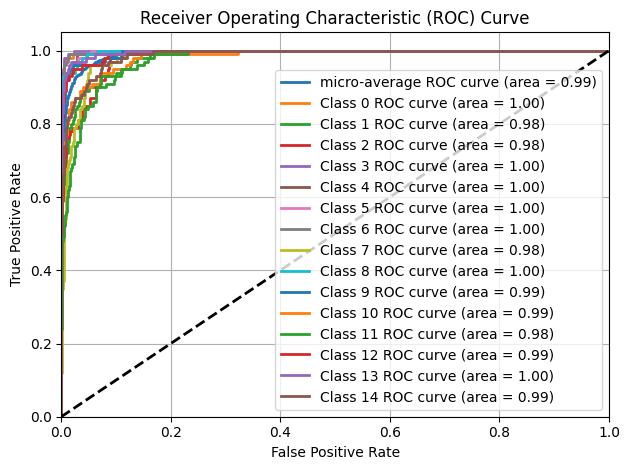

ROC curve saved to roc_curve.png


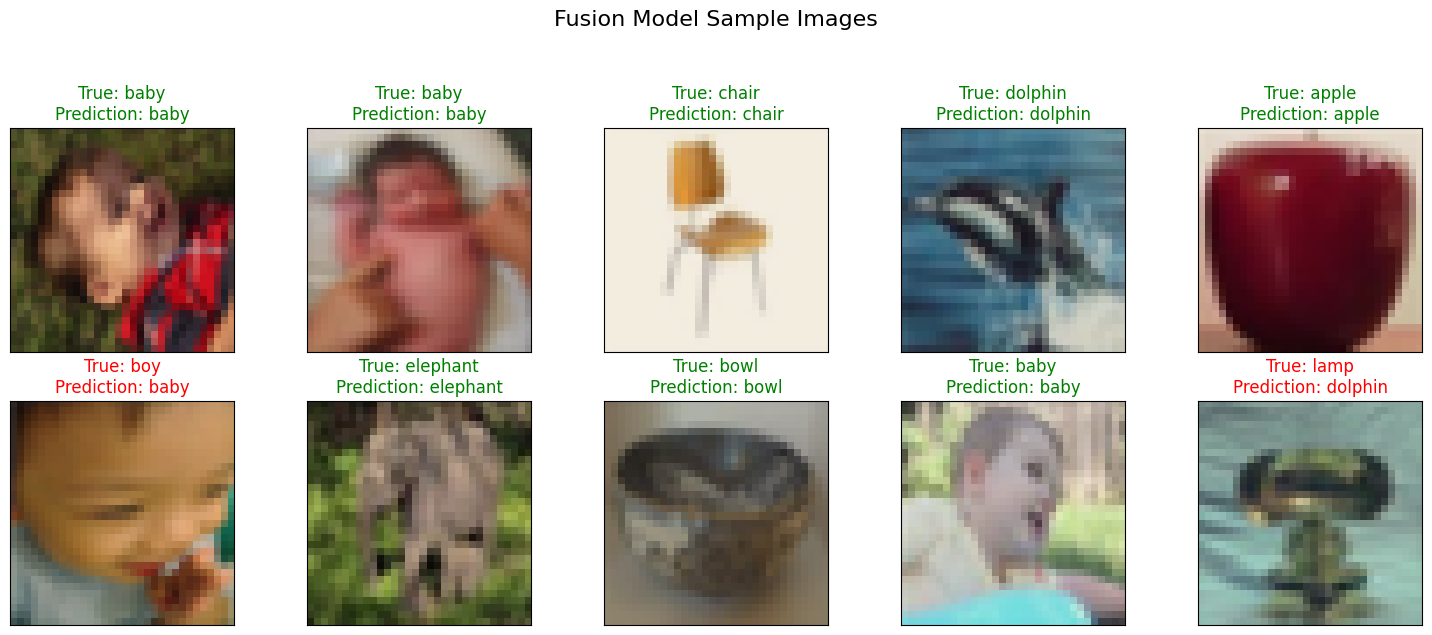

In [8]:
from sklearn.preprocessing import label_binarize

# Define the test transformation: convert image to tensor and normalize
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])


# Custom Dataset to load our data
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        # If the image is a tensor, convert it to a PIL image for processing
        if isinstance(image, torch.Tensor):
            image = transforms.functional.to_pil_image(image)
        if self.transform:
            image = self.transform(image)
        return image, label


# Function to load data from a .pth file
def load_data(data_path):
    raw = torch.load(data_path)
    data = raw['data']
    labels = raw['labels']
    return data, labels

mapping = {0: 0, 40: 1, 10: 2, 20: 3, 30: 4, 1: 5, 41: 6, 11: 7, 21: 8, 31: 9, 32: 10, 2: 11, 42: 12, 12: 13, 22: 14}

# Function to load combined data from multiple subclass files
def load_combined_data(subclass_files, train=True):
    all_data = []
    all_labels = []
    for i, files in enumerate(subclass_files):
        # Choose train or test file based on the flag
        file_path = files["train"] if train else files["test"]
        data, labels = load_data(file_path)
        mapping = files["mapping"]
        offset = i * 5  # Adjust labels for each subclass
        new_labels = [mapping[label] + offset for label in labels]
        all_data.append(data)
        all_labels.extend(new_labels)
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.tensor(all_labels, dtype=torch.long)
    return all_data, all_labels


# List of subclass files used in training
subclass_files = [
    {
        "train": "/content/TaskA/Model1/model1_train.pth",
        "test": "/content/TaskA/Model1/model1_test.pth",
        "mapping": {0: 0, 40: 1, 10: 2, 20: 3, 30: 4}
    },
    {
        "train": "/content/TaskA/Model2/model2_train.pth",
        "test": "/content/TaskA/Model2/model2_test.pth",
        "mapping": {1: 0, 41: 1, 11: 2, 21: 3, 31: 4}
    },
    {
        "train": "/content/TaskA/Model3/model3_train.pth",
        "test": "/content/TaskA/Model3/model3_test.pth",
        "mapping": {32: 0, 2: 1, 42: 2, 12: 3, 22: 4}
    }
]


# Define the CNN model architecture (the same architecture used for fine-tuning)
class CustomCNN(nn.Module):
    def __init__(self, num_classes=15, dropout_rate=0.2):
        super(CustomCNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Function to evaluate the model and collect predictions, labels, and probabilities
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_images = []

    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        for inputs, labels in test_loader:
            all_images.append(inputs.cpu())
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Get probabilities from softmax
            probs = softmax(outputs)
            # Get the predicted class
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return torch.cat(all_images, 0), np.array(all_labels), np.array(all_preds), np.array(all_probs)


# Function to plot ROC curve for multi-class classification
def plot_roc_curve(y_true, y_score, n_classes, save_path="roc_curve.png"):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label='Class {0} ROC curve (area = {1:0.2f})'.format(i, roc_auc[i]),
                 linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print("ROC curve saved to", save_path)


def main():
    # Initialize the model architecture (15 classes)
    model = CustomCNN(num_classes=15)

    # Load the fine-tuned model weights
    model_path = "/content/TaskA/Models/merged_model_finetuned_taskA.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    # Load the combined test data using the subclass files
    combined_test_data, combined_test_labels = load_combined_data(subclass_files, train=False)

    # Create test dataset and DataLoader
    test_dataset = CustomDataset(combined_test_data, combined_test_labels, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Evaluate the model on the test dataset
    all_img, y_true, y_pred, y_prob = evaluate_model(model, test_loader, device)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print("Test Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot the ROC curve for multi-class classification
    plot_roc_curve(y_true, y_prob, n_classes=15, save_path="roc_curve.png")

    num_total = len(all_img)
    indices = random.sample(range(num_total), 10)

    fig = display_images(all_img[indices], y_true[indices], y_pred[indices], list(mapping.keys()), indices, -1, classes_names_A)
    plt.tight_layout()
    plt.show()

main()


# Fusion Model - Task B

Test Accuracy: 54.9333%
Precision: 0.5081
Recall: 0.5493
F1 Score: 0.5178


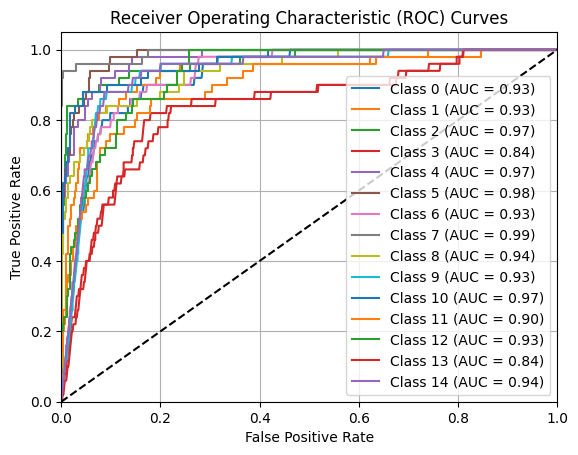

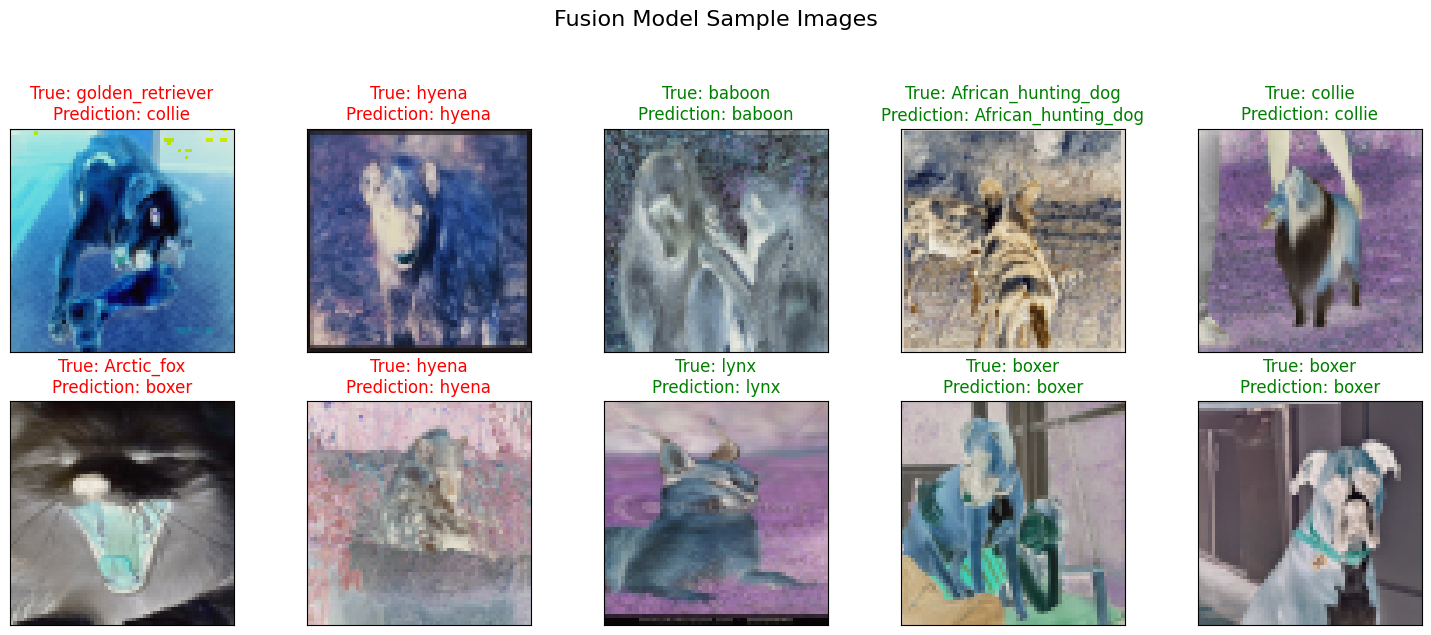

In [9]:

# --- Define the test transform ---
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])


# --- Custom Dataset class ---
class CustomDataset(Dataset):
    """
    Custom dataset for loading image data and labels.
    Converts tensor images to PIL images if necessary, then applies the transform.
    """

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        # If the image is a tensor and has 3 channels in the last dimension, permute it to (C, H, W)
        if isinstance(image, torch.Tensor):
            if image.ndim == 3 and image.shape[-1] == 3:
                image = image.permute(2, 0, 1).cpu()
            image = transforms.functional.to_pil_image(image)
        if self.transform:
            image = self.transform(image)
        return image, label


# --- Custom CNN model definition ---
class CustomCNN(nn.Module):
    """
    CNN model with four convolutional blocks, global average pooling,
    and a final classifier.
    """

    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# --- Data loading helper functions ---
def load_data(file_path):
    """
    Loads data and labels from a .pth file.
    """
    data = torch.load(file_path)
    return data['data'], data['labels']


def load_combined_data(subclass_files, train=True):
    """
    Combines data and labels from multiple subclasses.
    Applies an offset to the labels so that the classes are in the range [0, 15) for 3 domains x 5 classes.
    """
    all_data = []
    all_labels = []
    for i, files in enumerate(subclass_files):
        file_path = files["train"] if train else files["test"]
        data, labels = load_data(file_path)
        mapping = files["mapping"]
        offset = i * 5
        # Map each label and apply the offset
        new_labels = [mapping[int(label)] + offset for label in labels]
        all_data.append(data)
        all_labels.extend(new_labels)
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.tensor(all_labels, dtype=torch.long)
    return all_data, all_labels


# --- Main evaluation function ---
def main():
    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # mapping = {34: 0, 137: 1, 159: 2, 173: 3, 201: 4, 24: 5, 34: 6, 80: 7, 135: 8, 202: 9, 124: 10, 125: 11,130: 12, 173: 13, 202: 14}
    kv_mapping = {0 : 34, 1 : 137, 2 : 159, 3 : 173, 4 : 201, 5 : 24, 6 : 34, 7 : 80, 8: 135, 9 : 202, 10 : 124, 11 : 125, 12 : 130, 13 : 173, 14 : 202}

    # Define subclass file information (paths and label mappings)
    subclass = [
        {"train": "/content/TaskB/Model1/model1_train.pth", "test": "/content/TaskB/Model1/model1_test.pth",
         "mapping": {34: 0, 137: 1, 159: 2, 173: 3, 201: 4}},
        {"train": "/content/TaskB/Model2/model2_train.pth", "test": "/content/TaskB/Model2/model2_test.pth",
         "mapping": {24: 0, 34: 1, 80: 2, 135: 3, 202: 4}},
        {"train": "/content/TaskB/Model3/model3_train.pth", "test": "/content/TaskB/Model3/model3_test.pth",
         "mapping": {124: 0, 125: 1, 130: 2, 173: 3, 202: 4}}
    ]

    classes_B = [
        "hyena",
        "baboon",
        "Arctic_fox",
        "Chihuahua",
        "lynx",
        "African_elephant",
        "hyena",
        "zebra",
        "patas",
        "African_hunting_dog",
        "collie",
        "golden_retriever",
        "boxer",
        "Chihuahua",
        "African_hunting_dog"
    ]

    # Load the combined test data and labels
    combined_test_data, combined_test_labels = load_combined_data(subclass, train=False)

    # Create the test dataset and DataLoader
    test_dataset = CustomDataset(combined_test_data, combined_test_labels, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Load the fine-tuned merged model
    model_path = "/content/TaskB/Models/merged_model_finetuned.pth"
    model = CustomCNN(num_classes=15)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Initialize lists to store true labels, predictions, and probability scores
    all_true = []
    all_preds = []
    all_probs = []
    all_images = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            all_images.append(inputs.cpu())
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Apply softmax to get probability scores
            probabilities = torch.softmax(outputs, dim=1)
            # Get predicted class indices
            preds = torch.argmax(probabilities, dim=1)
            all_true.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.append(probabilities.cpu().numpy())
    all_img = torch.cat(all_images, 0)
    # Concatenate all probability arrays
    all_probs = np.concatenate(all_probs, axis=0)

    # Compute evaluation metrics using sklearn
    accuracy = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_true, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_true, all_preds, average='macro', zero_division=0)

    print("Test Accuracy: {:.4f}%".format(accuracy * 100))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))

    # --- Compute ROC curve and AUC for each class ---
    n_classes = 15
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Convert true labels to one-hot encoding for multi-class ROC computation
    true_one_hot = np.zeros((len(all_true), n_classes))
    for i, label in enumerate(all_true):
        true_one_hot[i, label] = 1

    # Compute ROC curve and AUC for each class using one-vs-rest approach
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_one_hot[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for all classes
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig("roc_curve.png")  # Save the ROC curve plot as a PNG file
    plt.show()

    num_total = len(all_img)
    indices = random.sample(range(num_total), 10)

    all_preds = np.array(all_preds)
    all_true = np.array(all_true)
    # print(f"selected labels: {all_true[indices]}")
    # print(f"selected preds: {all_preds[indices]}")
    # print(f"class key: {list(kv_mapping.keys())}")
    fig = display_images(all_img[indices], all_true[indices], all_preds[indices], list(kv_mapping.keys()), indices, -1, classes_B)
    plt.tight_layout()
    plt.show()

main()
